In [1]:
%matplotlib inline
# version check
import numpy
print('The numpy version is {}.'.format(numpy.__version__))
import pandas
print('The pandas version is {}.'.format(pandas.__version__))
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
import matplotlib
print('The matplotlib version is {}.'.format(matplotlib.__version__))
import regex
print('The regex version is {}.'.format(regex.__version__))

The numpy version is 1.18.1.
The pandas version is 1.0.4.
The scikit-learn version is 0.23.1.
The matplotlib version is 3.2.1.
The regex version is 2.5.80.


## Import data

In [2]:
# import pandas
import pandas as pd
# viewing options
pd.set_option('max_colwidth', 150)
pd.options.display.max_rows = 300

In [3]:
%%time
# import dataframe, drop duplicates
main_df = pd.read_csv('./data/enron/02_processed_body.csv', index_col=0)

Wall time: 12.4 s


In [4]:
main_df.head(2)

,f_dir,m_id,m_date,m_from,m_to,m_cc,m_bcc,m_subj,mime_vers,cont_type,...,x_cc,x_bcc,x_fold,x_orig,x_fname,m_body,gender,clean_name,original_index,p_body
0,./data/maildir/allen-p/_sent_mail/1,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,NaN,NaN,NaN,1.0,text/plain; charset=us-ascii,...,NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail",Allen-P,pallen (Non-Privileged).pst\n\n,Here is our forecast\n\n,0.0,phillip allen,0,here is our forecast
1,./data/maildir/allen-p/_sent_mail/10,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,NaN,NaN,Re:,1.0,text/plain; charset=us-ascii,...,NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail",Allen-P,pallen (Non-Privileged).pst\n\n,Traveling to have a business meeting takes the fun out of the trip. Especially if you have to prepare a presentation. I would suggest holding th...,0.0,phillip allen,1,traveling to have business meeting take the fun out of the trip especially if you have to prepare presentation would suggest holding the business ...


## Monitoring impact on labels
We want to keep an eye on the male/female ratio when filtering out our dataset (especially when blanket removing things like 'duplicates', where the filtering can be applied to either label for the same condition) so that our label ratio isn't significantly unbalanced as a result.

In [5]:
def monitor_label(df):
    b = df.groupby(['gender']).size()[0]
    g = df.groupby(['gender']).size()[1]
    print('Frame Size: {} observations\nboy: {}\ngirl: {}\nB/G Ratio: {:.3f} ({:.0f}%, {:.0f}%)'.format(len(df), b, g, b/g, b*100/(b+g), g*100/(b+g)))
    
monitor_label(main_df)

Frame Size: 409923 observations
boy: 235804
girl: 174119
B/G Ratio: 1.354 (58%, 42%)


## Remove NaN from gender, body

In [6]:
# set dataframe to not NaN gender returns
main_df = main_df[main_df.gender.notna()]
_ = main_df[main_df.m_body.isna()].index
main_df = main_df.drop(_) # drop from email body
_ = main_df[main_df.p_body.isna()].index
main_df = main_df.drop(_) # drop from processed body
monitor_label(main_df)

Frame Size: 409719 observations
boy: 235664
girl: 174055
B/G Ratio: 1.354 (58%, 42%)


## Reset index
Prior to using the indices and indexes to reference data in the dataframe, we'll need to reset the index so the values line up. We'll keep the original index incase it is needed later.

In [7]:
# reindex dataframe for cosine similarity matching
main_df = main_df.reset_index(drop=False)
main_df['original_index'] = main_df.index.copy()
main_df = main_df.drop('index', axis=1)
main_df.head(2)
print(main_df.info())
monitor_label(main_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409719 entries, 0 to 409718
Data columns (total 23 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   f_dir           409719 non-null  object 
 1   m_id            409719 non-null  object 
 2   m_date          409719 non-null  object 
 3   m_from          409719 non-null  object 
 4   m_to            402245 non-null  object 
 5   m_cc            120760 non-null  object 
 6   m_bcc           114775 non-null  object 
 7   m_subj          392380 non-null  object 
 8   mime_vers       409719 non-null  float64
 9   cont_type       409719 non-null  object 
 10  encode          409719 non-null  object 
 11  x_from          409719 non-null  object 
 12  x_to            404566 non-null  object 
 13  x_cc            115574 non-null  object 
 14  x_bcc           172 non-null     object 
 15  x_fold          409719 non-null  object 
 16  x_orig          409719 non-null  object 
 17  x_fname   

## Randomize dataframe

In [8]:
main_df = main_df.sample(len(main_df),random_state=42).reset_index(drop=True)

## Emails per sender

m_from
kay.mann@enron.com           16726
vince.kaminski@enron.com     14360
jeff.dasovich@enron.com      11405
pete.davis@enron.com          9149
chris.germany@enron.com       8796
sara.shackleton@enron.com     8777
tana.jones@enron.com          8489
steven.kean@enron.com         6751
kate.symes@enron.com          5438
matthew.lenhart@enron.com     5242
dtype: int64

       emails_per_sender
count        8202.000000
mean           49.953548
std           407.846066
min             1.000000
25%             2.000000
50%             4.000000
75%            15.000000
max         16726.000000


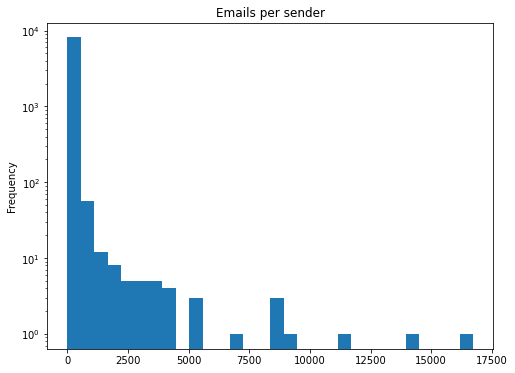

In [9]:
import numpy as np
import matplotlib.pyplot as plt
df_sender = pd.DataFrame(main_df.groupby(['m_from']).size(), columns=['emails_per_sender'])
df_sender = df_sender.sort_values('emails_per_sender', ascending=False)
df_sender['emails_per_sender'].plot(kind='hist', bins=30, logy=True, title='Emails per sender', figsize=(8,6))
print(main_df.groupby(['m_from']).size().sort_values(ascending=False)[:10])
print()
print(df_sender.describe())
plt.show()

## LSA dimension reduction (truncated SVD) from Tfidf, Used to identify duplicates

In [10]:
%%time
def svd_decom(df, n, n_components=5, n_iter=5, hline=1.0):
    X = df.p_body.values[:n]
    y = df.gender.values[:n]
    from sklearn.feature_extraction.text import TfidfVectorizer
    t_vect = TfidfVectorizer(sublinear_tf=True)
    X = t_vect.fit_transform(X)
    from sklearn.decomposition import TruncatedSVD
    svd = TruncatedSVD(n_components=n_components, n_iter=n_iter, random_state=42)
    X = svd.fit_transform(X)
    import matplotlib.pyplot as plt
    colors = {0:'b', 1:'r'}
    plt.scatter(X[:, 0], X[:, 1], c=[colors[x] for x in y], alpha=0.25)
    plt.axhline(hline, color='g', linestyle=':')
    plt.title('LSA Dimension Reduction with Sublinear Tf (1 + log(tf))')
    plt.show()
    _ = pd.DataFrame(zip(X[:, 0], X[:, 1]))
    duplicate_idx = _[_[1]>hline].index
    print('Above %2.f Threshold:' % (hline))
    print(df.iloc[duplicate_idx,:].gender.describe())
    print()
    print(df.iloc[duplicate_idx,:].groupby(['m_from']).size().sort_values(ascending=False)[:10])
    print()
    print(df.iloc[duplicate_idx,:].p_body)
    return _
    

Wall time: 0 ns


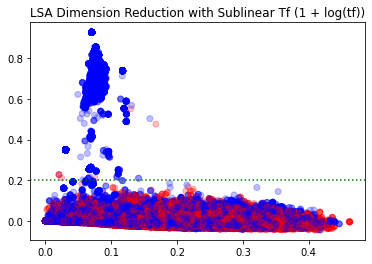

Above  0 Threshold:
count    8917.000000
mean        0.000673
std         0.025933
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: gender, dtype: float64

m_from
pete.davis@enron.com          8908
robert.walker@enron.com          2
monika.causholli@enron.com       2
elizabeth.sager@enron.com        2
lisa.gang@enron.com              1
karen.denne@enron.com            1
j..kean@enron.com                1
dtype: int64

28                                                                    start date hourahead hour hourahead schedule download failed manual intervention required
67        start date hourahead hour no ancillary schedule awarded variance detected variance detected in energy import export schedule variance detected in ...
172                                                                   start date hourahead hour hourahead schedule download failed manual intervention required
185       start date hourahead hour 

In [11]:
%%time
_ = svd_decom(main_df, len(main_df), hline=0.2)
#_ = svd_decom(main_df, 1000, hline=0.2)

## Remove duplicates above threshold; shuffle, reset df index

In [12]:
select_idx = _[_[1]<.20].index # remove query
main_df = main_df.iloc[select_idx,:]
main_df = main_df.sample(len(main_df),random_state=42).reset_index(drop=True) # shuffle, reset index

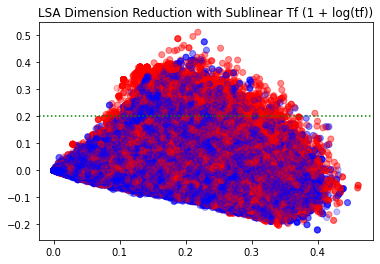

Above  0 Threshold:
count    16779.000000
mean         0.532928
std          0.498929
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: gender, dtype: float64

m_from
debra.perlingiere@enron.com    2709
tana.jones@enron.com           1522
sara.shackleton@enron.com      1335
vince.kaminski@enron.com       1142
kay.mann@enron.com              819
darron.giron@enron.com          520
steven.kean@enron.com           440
eric.bass@enron.com             425
phillip.love@enron.com          414
mark.taylor@enron.com           313
dtype: int64

79                                        debra perlingiere enron north america corp legal department smith street eb houston texas dperlin enron com phone fax
101       to michael walter hou ect ect harry bucalo hou ect ect neal winfree hou ect ect phillip love hou ect ect eric bass hou ect ect matthew lenhart hou...
118       carol st clair eb phone fax carol st clair enron com forwarded 

In [13]:
%%time
_ = svd_decom(main_df, len(main_df), hline=0.2)
#_ = svd_decom(main_df, 1000, hline=0.2)

## Model

In [14]:
import regex as re
def visualizer(df, n=1000, list_n=30, max_iter=100, n_jobs=None, min_df=1, max_df=1.0, token_pattern=r"\w{2,}", stop_words=None):

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib import rcParams
    sns.set_style("whitegrid")
    sns.set_context("notebook")
    import regex as re

    def plot_ecdf(x, xlab='', ylab='', title='', logx=False, logy=False, vline=None):
        x = np.sort(x)
        n = x.size
        y = np.arange(1, n+1) / n
        plt.scatter(x, y)
        plt.xlabel(xlab, fontsize=14)
        plt.ylabel(ylab, fontsize=14)
        plt.title(title)
        if logx == True:
            plt.xscale('log')
        if logy == True:
            plt.yscale('log')
        if vline is not None:
            plt.axvline(vline, color='r', linestyle='--')
        
    def plot_scatter(x, y, xlab='', ylab='', title='', logx=False, logy=False, ):
        plt.scatter(x, y, alpha=0.25)
        plt.xlabel(xlab)
        plt.ylabel(ylab)
        plt.title(title)
        if logx == True:
            plt.xscale('log')
        if logy == True:
            plt.yscale('log')
    
    # CREATE SAMPLE SUBSET
    X = df.p_body.values[:n]
    y = df.gender.values[:n]

    # FIT, TRANSFORM VECTORIZER
    from sklearn.feature_extraction.text import TfidfVectorizer
    vect = TfidfVectorizer(min_df=min_df, max_df=max_df, token_pattern=token_pattern, stop_words=stop_words)
    X = vect.fit_transform(X)
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

    # FIT, TRANSFORM MODEL
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression().fit(X_train, y_train)
    model_name = model.__class__.__name__

    # GET DATA
    fn = vect.get_feature_names() 
    fi = model.coef_[0] # get importance values from model output
    fc = X.toarray() # creates feature count matrix from CountVectorizer fit_transform object
    fc = np.sum(fc, 0) # sums the counts along the 0 axis (column) to produce word count
    _ = pd.DataFrame(zip(fn, fi, fc))
    _.columns = ['feature_name', 'feature_coef', 'feature_frequency']
    _['character_count'] = _.feature_name.str.count('[A-aZ-z]')

    # VISUALIZE
    plt.figure(figsize=(14,6))
    plt.subplot(1, 2, 1)
    plt.suptitle('Feature Coef', fontsize=16)
    _.feature_coef.plot(kind='hist', bins=10, logx=False, logy=True)   
    plt.subplot(1, 2, 2)
    plot_ecdf(_.feature_coef, xlab='x', ylab='y', logx=False, logy=False, vline=None)
    plt.show()
    print(_.feature_coef.describe())
    
    plt.figure(figsize=(14,6))
    plt.subplot(1, 2, 1)
    plt.suptitle('Feature Frequency (TfIdf)', fontsize=16)
    _.feature_frequency.plot(kind='hist', bins=10, logy=True)   
    plt.subplot(1, 2, 2)
    plot_ecdf(_.feature_frequency, xlab='x', ylab='y', logx=True, logy=False, vline=None)
    plt.show()
    print(_.feature_frequency.describe())
    
    plt.figure(figsize=(14,6))
    plt.subplot(1, 2, 1)
    plt.suptitle('Character Count', fontsize=16)
    _.character_count.plot(kind='hist', bins=10, logy=False)   
    plt.subplot(1, 2, 2)
    plot_ecdf(_.character_count, xlab='x', ylab='y', logx=True, logy=True, vline=None)
    plt.show()
    print(_.character_count.describe())  
    
    plt.figure(figsize=(14,6))
    plt.subplot(1, 2, 1)
    plot_scatter(_.feature_coef, _.feature_frequency, logy=True, title='Coefficient v. Frequency(TfIdf)')
    plt.subplot(1, 2, 2)
    plot_scatter(_.feature_coef, _.character_count, title='Coefficient v. Character Count')
    plt.show() 
    print(_.describe())  
    print()
    
    _ = _.sort_values('feature_coef', ascending=False)
    # plot lower feature importance
    plt.figure(figsize=(16,10)) # longer plot for word list
    plt.subplot(1, 2, 1)
    plt.plot(_.feature_coef[:-(list_n+1):-1].values, [x for x in range(len(_.feature_coef[:-(list_n+1):-1].values))], color='r') # values to xaxis
    plt.yticks(range(len(_.feature_name[:-(list_n+1):-1])), _.feature_name[:-(list_n+1):-1], fontsize=14) # labels to y-axis
    plt.ylim(list_n-1,0) # flip y-axis to descending
    plt.title('%s: Lowest %d Feature Importance' % (model_name, list_n), fontsize=16)
    
    # plot upper feature importance
    plt.subplot(1, 2, 2)
    plt.plot(_.feature_coef[:list_n].values, [x for x in range(len(_.feature_coef[:list_n].values))]) # values to xaxis
    plt.yticks(range(len(_.feature_name[:list_n])), _.feature_name[:list_n], fontsize=14) # labels to y-axis
    plt.ylim(list_n-1,0) # flip y-axis to descending
    plt.title('%s: Highest %d Feature Importance' % (model_name, list_n), fontsize=16)
    plt.show()    

    print()
    print(_[:list_n])
    print()
    print(_[:-(list_n+1):-1])
    print()
    
    # SCORE
    y_pred = model.predict(X_test)
    from sklearn.metrics import classification_report
    print(classification_report(y_test, y_pred))
    from sklearn.metrics import plot_roc_curve
    plot_roc_curve(model, X_test, y_test)

## Initial Observations

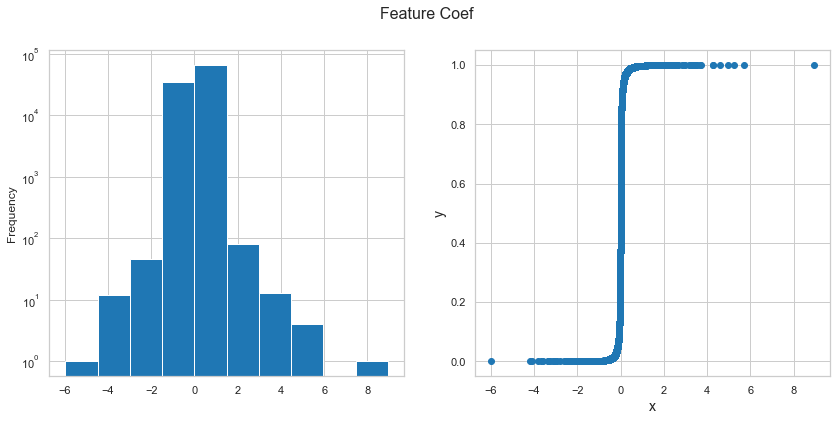

count    101272.000000
mean          0.001888
std           0.166291
min          -5.978644
25%          -0.016909
50%           0.000000
75%           0.011011
max           8.951298
Name: feature_coef, dtype: float64


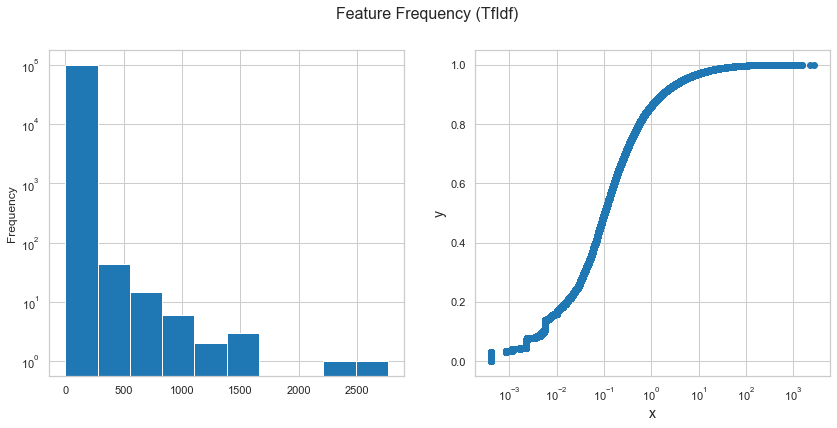

count    101272.000000
mean          2.035270
std          22.326584
min           0.000419
25%           0.028264
50%           0.103257
75%           0.384368
max        2766.923127
Name: feature_frequency, dtype: float64


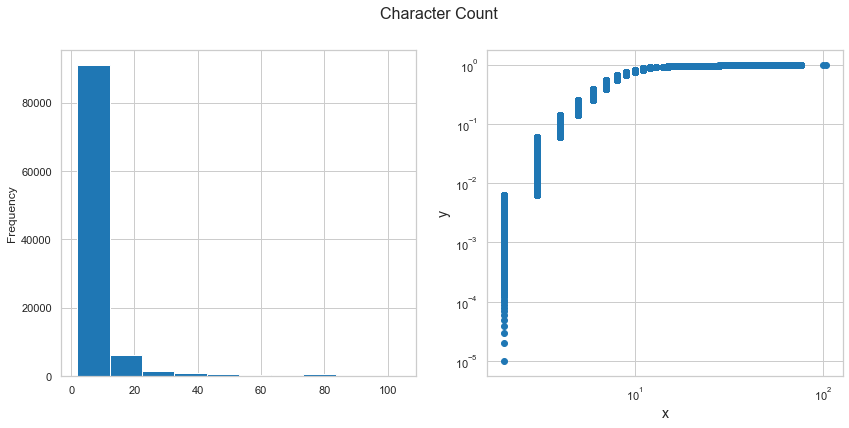

count    101272.000000
mean          9.044237
std           8.886996
min           2.000000
25%           5.000000
50%           7.000000
75%           9.000000
max         104.000000
Name: character_count, dtype: float64


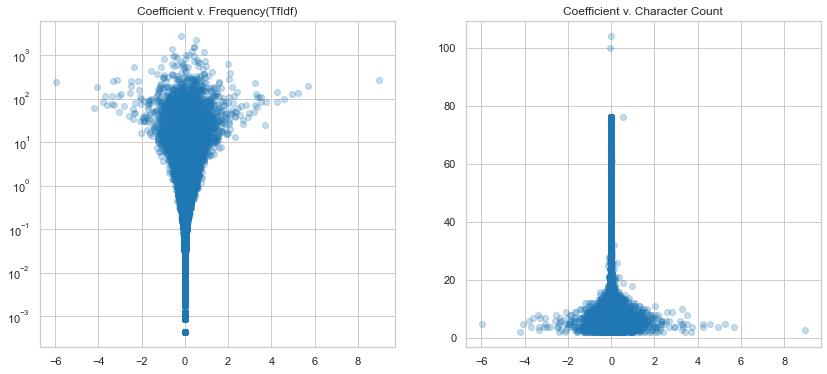

        feature_coef  feature_frequency  character_count
count  101272.000000      101272.000000    101272.000000
mean        0.001888           2.035270         9.044237
std         0.166291          22.326584         8.886996
min        -5.978644           0.000419         2.000000
25%        -0.016909           0.028264         5.000000
50%         0.000000           0.103257         7.000000
75%         0.011011           0.384368         9.000000
max         8.951298        2766.923127       104.000000



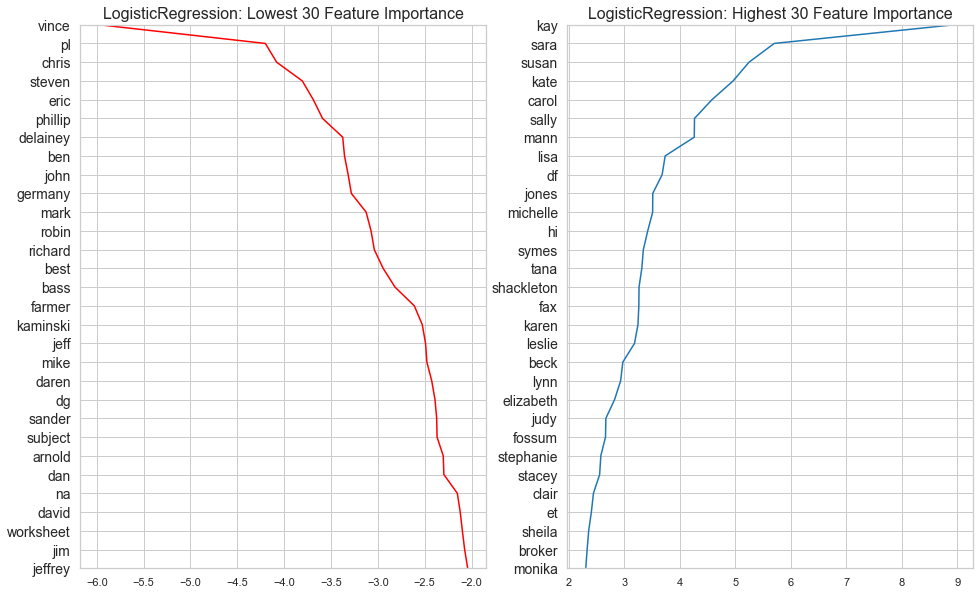


      feature_name  feature_coef  feature_frequency  character_count
48993          kay      8.951298         264.183618                3
79209         sara      5.699563         193.364477                4
86431        susan      5.246271         133.976603                5
48913         kate      4.958632         129.695549                4
15603        carol      4.578278          95.768454                5
78957        sally      4.263448          82.281215                5
55589         mann      4.259483         140.056133                4
53401         lisa      3.734997          82.486192                4
24791           df      3.680666          25.056726                2
47725        jones      3.511799         110.769970                5
58648     michelle      3.509563          84.070809                8
40836           hi      3.420849         108.604615                2
86876        symes      3.341824          65.802527                5
87306         tana      3.314531 

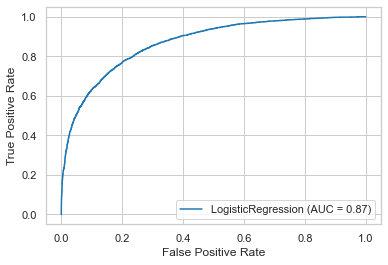

In [15]:
%%time
visualizer(main_df, n=30000, list_n=30, max_iter=500, n_jobs=-1, min_df=1, max_df=1.0, token_pattern=r"\w{2,}", stop_words=None)

## First Adjustment: Word Count (25ct-95%), Character Count(3-15)

In [16]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
print(stop_words)

{'her', 'up', 'those', "don't", "you're", 'further', 'down', 'of', "that'll", 'my', 'his', 'she', 'so', 'yourself', 'here', 'why', "mustn't", 'me', 'in', 'now', 'them', 'on', "aren't", 'y', 'itself', 'himself', 'ain', 'we', 'such', 'until', 'mustn', 'it', 'only', 'mightn', 'don', 'that', 'and', 'how', 'most', "needn't", 'be', 'couldn', 'just', 'at', "didn't", "wouldn't", 'very', 'more', 'hadn', 'myself', 'who', 'same', "hasn't", 'themselves', 's', 'with', 'where', 'ma', 'below', "haven't", 'any', 'or', 'your', 't', 'shouldn', "shouldn't", 'after', 'by', "it's", 'for', 'both', 'll', 'o', 'over', 'out', 'yours', 'weren', 'wasn', 'has', 'having', 'their', 'during', "wasn't", 'all', "mightn't", 'its', 'theirs', 'won', 'he', 'above', 'didn', 'between', 'doesn', 'are', 'him', 'they', 'to', "couldn't", 'been', 'was', 'against', 'nor', "won't", 'do', 'too', 'not', 'herself', 'have', 'shan', "you've", 'whom', "shan't", 'should', 'were', 'is', 'then', 'hasn', 'aren', 'yourselves', 'haven', 'into

C:\Users\james\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


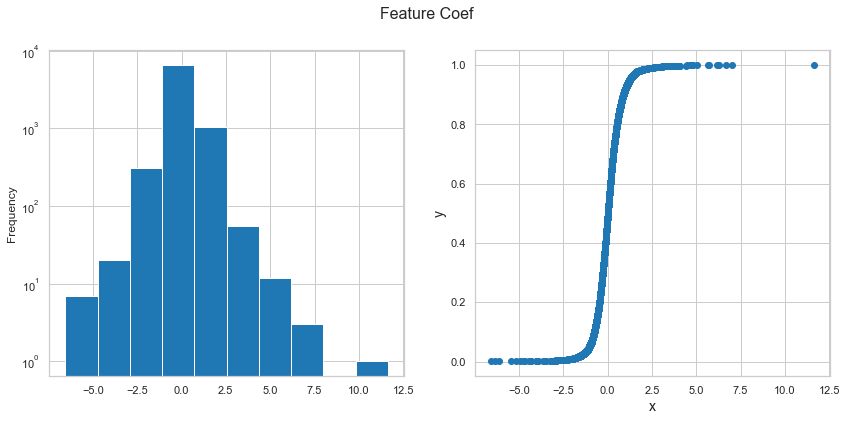

count    7982.000000
mean        0.044702
std         0.805097
min        -6.557365
25%        -0.362472
50%         0.012200
75%         0.412910
max        11.645318
Name: feature_coef, dtype: float64


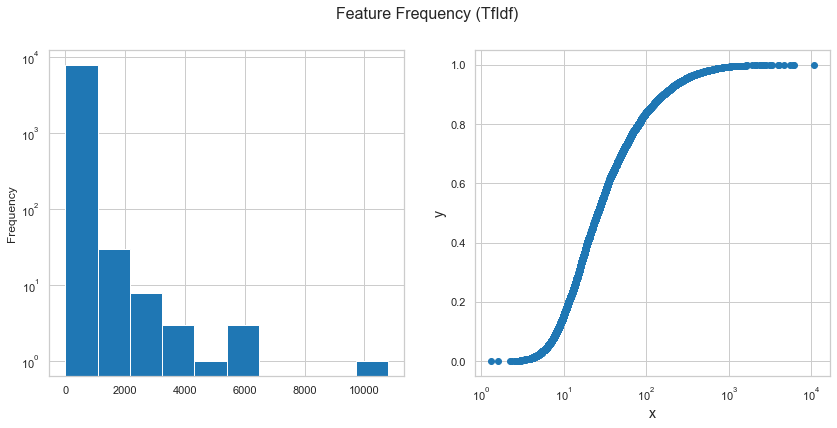

count     7982.000000
mean        78.346108
std        249.052476
min          1.330610
25%         13.400344
50%         25.751817
75%         63.003558
max      10787.225564
Name: feature_frequency, dtype: float64


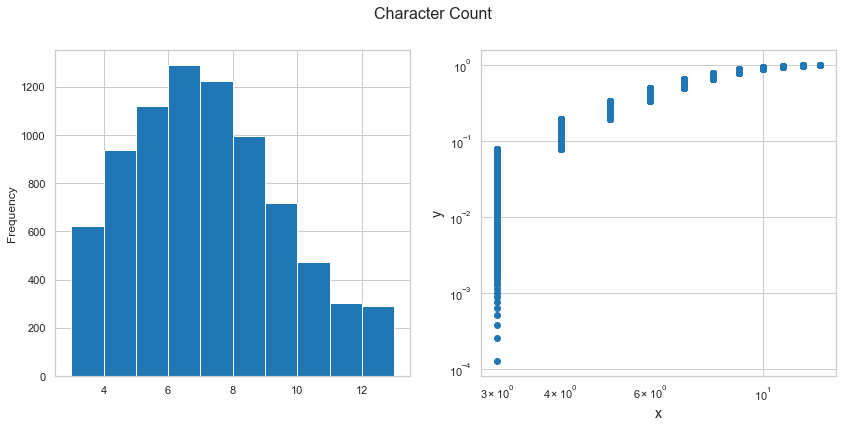

count    7982.000000
mean        6.728890
std         2.383728
min         3.000000
25%         5.000000
50%         7.000000
75%         8.000000
max        13.000000
Name: character_count, dtype: float64


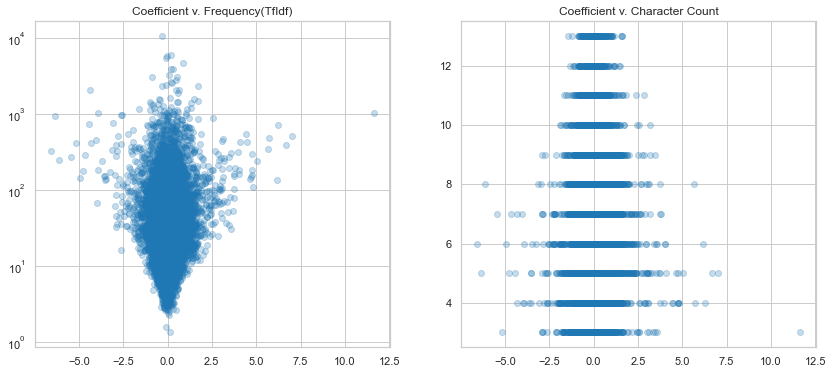

       feature_coef  feature_frequency  character_count
count   7982.000000        7982.000000      7982.000000
mean       0.044702          78.346108         6.728890
std        0.805097         249.052476         2.383728
min       -6.557365           1.330610         3.000000
25%       -0.362472          13.400344         5.000000
50%        0.012200          25.751817         7.000000
75%        0.412910          63.003558         8.000000
max       11.645318       10787.225564        13.000000



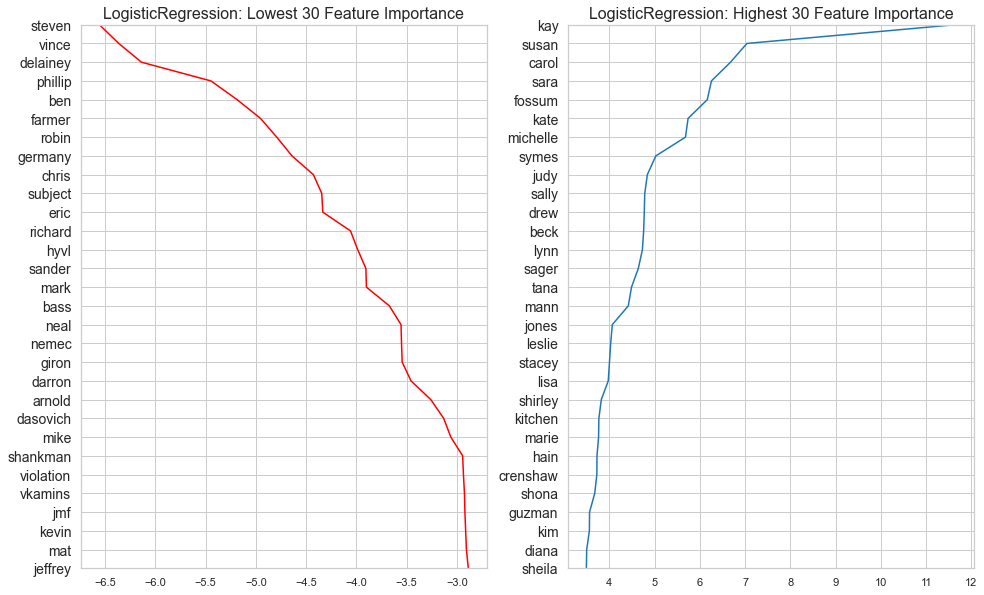


     feature_name  feature_coef  feature_frequency  character_count
3942          kay     11.645318        1033.358881                3
7048        susan      7.040519         514.833143                5
1066        carol      6.678697         392.956852                5
6334         sara      6.256855         726.619013                4
2885       fossum      6.165430         138.185684                6
3933         kate      5.740990         480.537728                4
4638     michelle      5.683104         349.949361                8
7076        symes      5.027948         242.691080                5
3893         judy      4.840954         109.041687                4
6308        sally      4.783610         298.408611                5
2182         drew      4.773262         183.148510                4
672          beck      4.759154         159.879531                4
4363         lynn      4.731834         150.681687                4
6303        sager      4.641863         139.303

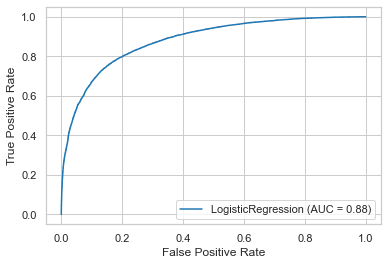

In [17]:
%%time
visualizer(main_df, n=100000, list_n=30, max_iter=500, n_jobs=-1, min_df=100, max_df=0.99, token_pattern=r"\w{3,13}", stop_words=None)

## Second Adjustment: Word Count (), Character Count()

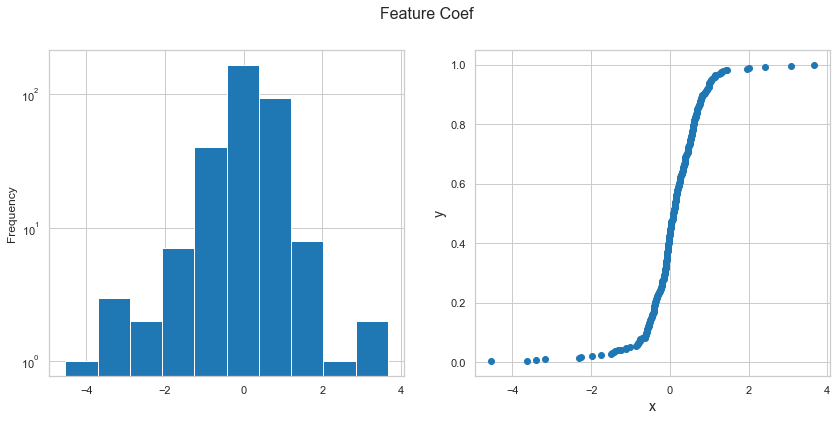

count    323.000000
mean       0.086536
std        0.793876
min       -4.537366
25%       -0.217796
50%        0.089705
75%        0.524055
max        3.666737
Name: feature_coef, dtype: float64


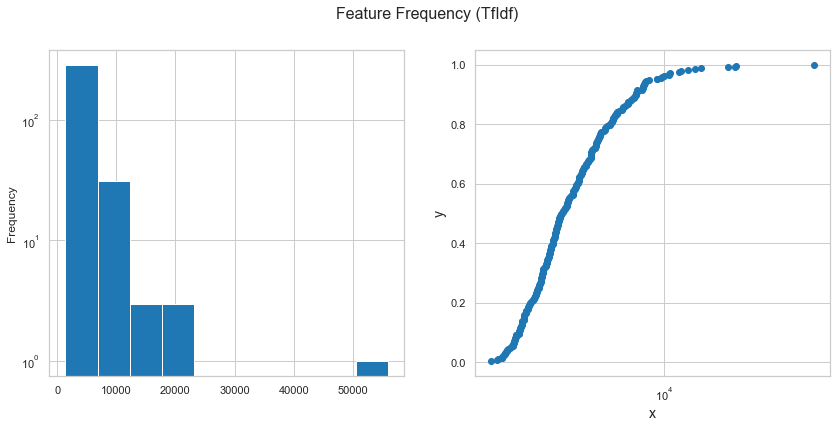

count      323.000000
mean      4179.681601
std       4054.938020
min       1365.923412
25%       2355.964713
50%       3095.781631
75%       4690.280025
max      55961.656697
Name: feature_frequency, dtype: float64


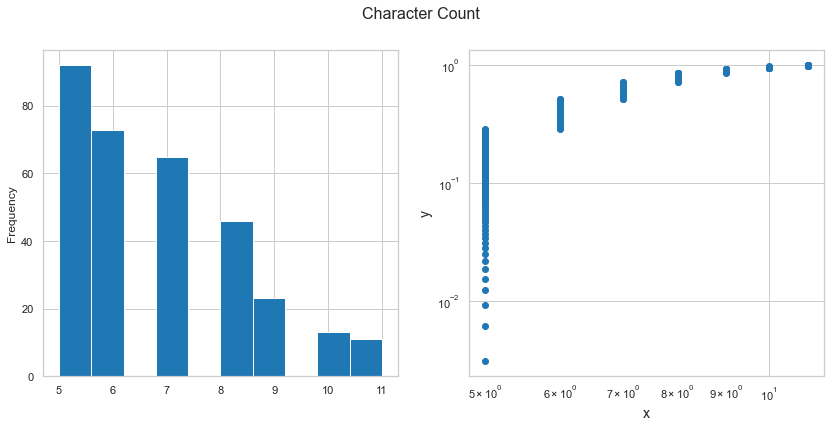

count    323.000000
mean       6.746130
std        1.625861
min        5.000000
25%        5.000000
50%        6.000000
75%        8.000000
max       11.000000
Name: character_count, dtype: float64


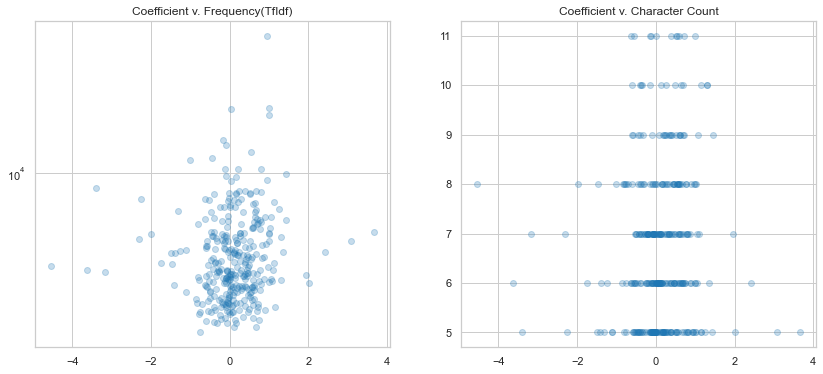

       feature_coef  feature_frequency  character_count
count    323.000000         323.000000       323.000000
mean       0.086536        4179.681601         6.746130
std        0.793876        4054.938020         1.625861
min       -4.537366        1365.923412         5.000000
25%       -0.217796        2355.964713         5.000000
50%        0.089705        3095.781631         6.000000
75%        0.524055        4690.280025         8.000000
max        3.666737       55961.656697        11.000000



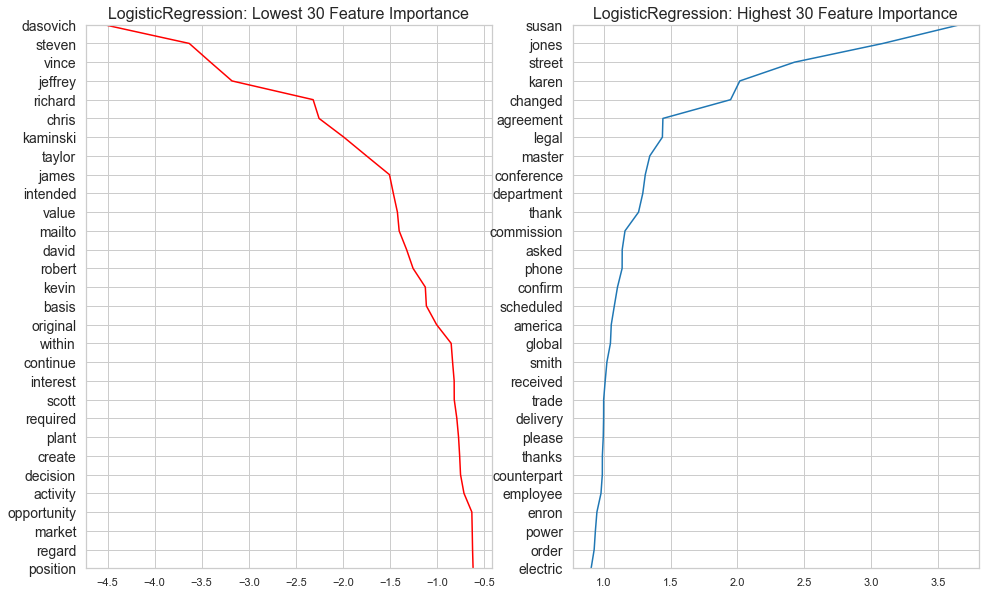


    feature_name  feature_coef  feature_frequency  character_count
273        susan      3.666737        4787.068330                5
147        jones      3.089005        4271.300789                5
269       street      2.426794        3758.977647                6
149        karen      2.017457        2547.933165                5
47       changed      1.948426        2808.524888                7
15     agreement      1.441561        9943.920368                9
153        legal      1.437728        5567.485366                5
165       master      1.343309        3732.679538                6
58    conference      1.309542        4507.805051               10
80    department      1.290812        2639.136958               10
278        thank      1.259044        6412.246025                5
53    commission      1.157669        1877.174394               10
26         asked      1.136862        3253.908531                5
200        phone      1.136164        7010.715036            

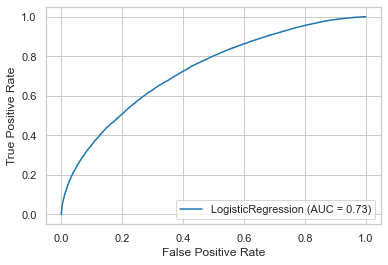

In [18]:
%%time
visualizer(main_df, n=400000, list_n=30, max_iter=500, n_jobs=-1, min_df=.03, max_df=0.97, token_pattern=r"\w{5,11}", stop_words=None)

## QC Feature, Label data

## Export dataset

In [19]:
# main_df.to_csv('./data/enron/03_filtered_dataset.csv')

In [20]:
len(main_df)

400802